# Mid-Price-Classification

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, LSTM, TimeDistributed, GRU, SimpleRNN
from keras.models import Model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import re

## Get the Data

Drop the redundant data

In [4]:
file_1='./LOBs_Benchmark/processed_data.csv'
data=pd.read_csv(file_1)

In [5]:
data.drop(['Mid_Price', 'Next_mid', 'Price_move'], axis=1, inplace=True) #deleting Mid and the other extra columns
data

,Time,level1_Bid_Price,level1_Bid_Volume,level1_Ask_Price,level1_Ask_Volume,level2_Bid_Price,level2_Bid_Volume,level2_Ask_Price,level2_Ask_Volume,level3_Bid_Price,...,level4_Bid_Volume,level4_Ask_Price,level4_Ask_Volume,level5_Bid_Price,level5_Bid_Volume,level5_Ask_Price,level5_Ask_Volume,Quoted_spread,Weighted_Mid_Price,up_or_down
0,0.217,258.0,12.0,262.0,2.0,257.0,6.0,263.0,4.0,256.0,...,7.0,346.0,3.0,99.0,9.0,596.0,2.0,4.0,261.428571,1
1,0.124,259.0,2.0,262.0,2.0,258.0,12.0,263.0,4.0,257.0,...,2.0,346.0,3.0,249.0,7.0,596.0,2.0,3.0,260.500000,1
2,0.062,259.0,2.0,262.0,2.0,258.0,10.0,263.0,4.0,257.0,...,2.0,346.0,3.0,254.0,2.0,596.0,2.0,3.0,260.500000,1
3,0.093,260.0,1.0,262.0,2.0,259.0,2.0,263.0,4.0,258.0,...,6.0,346.0,3.0,256.0,2.0,596.0,2.0,2.0,260.666667,1
4,0.093,260.0,1.0,262.0,2.0,259.0,2.0,264.0,4.0,258.0,...,6.0,346.0,3.0,256.0,2.0,596.0,2.0,2.0,260.666667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893708,0.186,249.0,8.0,283.0,5.0,246.0,22.0,523.0,3.0,244.0,...,7.0,724.0,4.0,132.0,1.0,795.0,4.0,34.0,269.923077,0
893709,0.124,249.0,8.0,282.0,5.0,246.0,22.0,523.0,3.0,244.0,...,7.0,724.0,4.0,132.0,1.0,795.0,4.0,33.0,269.307692,1
893710,0.031,249.0,8.0,282.0,5.0,246.0,22.0,523.0,3.0,244.0,...,7.0,724.0,4.0,132.0,1.0,795.0,4.0,33.0,269.307692,1
893711,0.248,249.0,8.0,282.0,5.0,246.0,22.0,523.0,3.0,244.0,...,15.0,724.0,4.0,132.0,1.0,795.0,4.0,33.0,269.307692,0


In [6]:
data.corr()['up_or_down'].sort_values(ascending=False)

up_or_down            1.000000
level1_Bid_Volume     0.036585
level5_Ask_Price      0.012034
level2_Ask_Volume     0.008924
level4_Ask_Price      0.007606
level3_Ask_Volume     0.007179
level5_Ask_Volume     0.003279
level4_Ask_Volume     0.003075
level1_Ask_Volume     0.000593
level1_Bid_Price     -0.000340
level3_Ask_Price     -0.002564
level2_Bid_Volume    -0.006468
Time                 -0.008950
level2_Bid_Price     -0.009482
level3_Bid_Volume    -0.010593
level4_Bid_Volume    -0.014454
level5_Bid_Volume    -0.017810
level3_Bid_Price     -0.025316
level2_Ask_Price     -0.027420
level4_Bid_Price     -0.042475
level5_Bid_Price     -0.060787
Weighted_Mid_Price   -0.063801
level1_Ask_Price     -0.087225
Quoted_spread        -0.088672
Name: up_or_down, dtype: float64

### Split the data

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
data=data.astype(np.float32)
df_input=data.drop(columns=['up_or_down'])
df_target=data['up_or_down']
df_target = np.expand_dims(df_target, axis=1)
y_binary = to_categorical(df_target)
print(y_binary.shape)
X_train,X_test, y_train, y_test = train_test_split(df_input, y_binary,test_size=0.2,shuffle=False)
print(len(X_train), len(y_train), len(X_test), len(y_test))

(893713, 2)
714970 714970 178743 178743


### Do the normalization

In [8]:
from sklearn.preprocessing import StandardScaler
feature_scaler=StandardScaler()
X_train=feature_scaler.fit_transform(X_train)
X_test=feature_scaler.transform(X_test)

### Reshape the data

In [9]:
def reshape_to_batches(a, batch_size):
    #pad if the length is not divisible by the batch_size
    batch_num = np.ceil(a.shape[0] / float(batch_size))
    modulo = batch_num * batch_size - a.shape[0]
    if modulo != 0:
        pad = np.zeros((int(modulo), a.shape[1]))
        a = np.vstack((a, pad))
    return np.array(np.split(a, batch_num))

In [10]:
batch_size = 30 #30 is about 165 minute (5.5min per ts x 30), tried 15 and a few other values too but 30 seems to be the best

X_train_batch = reshape_to_batches(X_train, batch_size)
y_train_batch = reshape_to_batches(y_train, batch_size)
print(X_train_batch.shape, y_train_batch.shape)

X_test_batch = reshape_to_batches(X_test, batch_size)
y_test_batch = reshape_to_batches(y_test, batch_size)
print(X_test_batch.shape, y_test_batch.shape)

(23833, 30, 23) (23833, 30, 2)
(5959, 30, 23) (5959, 30, 2)


## Create a simple RNN classifier

In [10]:
def classification_result(y_pred, thresh=0.5):
  cutt_off_tr = thresh # some threshold

  y_pred[np.where(y_pred >= cutt_off_tr)] = 1
  y_pred[np.where(y_pred < cutt_off_tr)]  = 0

  print(confusion_matrix(
         y_test_batch.flatten(), y_pred.flatten()))

  print()
  print(classification_report(
          y_test_batch.flatten(),
          y_pred.flatten(),
          target_names = ["Down", "Up"],
          digits = 5))

In [11]:
model_rnn=Sequential()
model_rnn.add(InputLayer((batch_size,23)))
rnn = SimpleRNN(128, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
                bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None,
                activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0,
                recurrent_dropout=0.0, return_sequences=True, return_state=False, go_backwards=False, stateful=False, unroll=False)
model_rnn.add(rnn)
model_rnn.add(TimeDistributed(Dense(2,activation='softmax')))
model_rnn.summary()
model_rnn.compile(optimizer='rmsprop', #learning rate algo
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30, 128)           19456     
                                                                 
 time_distributed (TimeDistr  (None, 30, 2)            258       
 ibuted)                                                         
                                                                 
Total params: 19,714
Trainable params: 19,714
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_rnn.fit(X_train_batch, y_train_batch, epochs=500, batch_size=100)

Epoch 1/500


2023-05-06 13:43:41.364823: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


239/239 [==============================] - 4s 15ms/step - loss: 0.4762 - accuracy: 0.8104
Epoch 2/500
239/239 [==============================] - 3s 14ms/step - loss: 0.4557 - accuracy: 0.8225
Epoch 3/500
239/239 [==============================] - 3s 14ms/step - loss: 0.4535 - accuracy: 0.8228
Epoch 4/500
239/239 [==============================] - 3s 14ms/step - loss: 0.4523 - accuracy: 0.8229
Epoch 5/500
239/239 [==============================] - 3s 14ms/step - loss: 0.4512 - accuracy: 0.8230
Epoch 6/500
239/239 [==============================] - 3s 14ms/step - loss: 0.4506 - accuracy: 0.8231
Epoch 7/500
239/239 [==============================] - 3s 14ms/step - loss: 0.4500 - accuracy: 0.8231
Epoch 8/500
239/239 [==============================] - 3s 14ms/step - loss: 0.4493 - accuracy: 0.8231
Epoch 9/500
239/239 [==============================] - 3s 14ms/step - loss: 0.4487 - accuracy: 0.8233
Epoch 10/500
239/239 [==============================] - 3s 14ms/step - loss: 0.4483 - accuracy

In [13]:
y_pred = model_rnn.predict(X_test_batch)
classification_result(y_pred)

187/187 [==============================] - 1s 2ms/step
[[135208  43589]
 [ 43562 135181]]

              precision    recall  f1-score   support

        Down    0.75632   0.75621   0.75627    178797
          Up    0.75617   0.75629   0.75623    178743

    accuracy                        0.75625    357540
   macro avg    0.75625   0.75625   0.75625    357540
weighted avg    0.75625   0.75625   0.75625    357540



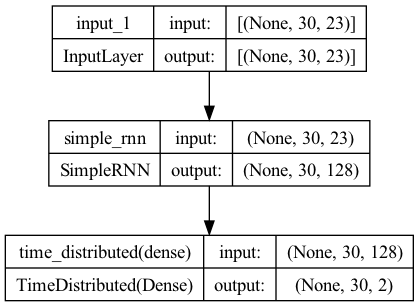

In [12]:
from keras.utils.vis_utils import plot_model #need to install graphviz and pydot for it to work
from IPython.display import Image
plot_model(model_rnn, to_file='./Images_model/classification_simple_rnn.png', show_shapes=True, show_layer_names=True)

Image(filename='./Images_model/classification_simple_rnn.png')

In [19]:
model_rnn.save('./models/classification_rnn')

INFO:tensorflow:Assets written to: ./models/classification_rnn/assets


## LSTM Model

In [13]:
from tensorflow.keras.optimizers import RMSprop
inputs = Input(shape=(batch_size, 23))

lstm = LSTM(32, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True,
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0,
            recurrent_dropout=0.00, implementation=1, return_sequences=True, return_state=False,
            go_backwards=False, stateful=False, unroll=False)(inputs)

predictions =  TimeDistributed(Dense(2, activation='softmax'))(lstm)
model = Model(inputs=inputs, outputs=predictions)

#my_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
my_optimizer = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0) #best
model.compile(optimizer=my_optimizer, #try default 'rmsprop'
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 23)]          0         
                                                                 
 lstm (LSTM)                 (None, 30, 32)            7168      
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 2)            66        
 tributed)                                                       
                                                                 
Total params: 7,234
Trainable params: 7,234
Non-trainable params: 0
_________________________________________________________________


/Users/yujiewang/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
history=model.fit(X_train_batch, y_train_batch, epochs=200, batch_size=100)

Epoch 1/200
239/239 [==============================] - 4s 15ms/step - loss: 0.4394 - accuracy: 0.8234
Epoch 2/200
239/239 [==============================] - 3s 14ms/step - loss: 0.4393 - accuracy: 0.8234
Epoch 3/200
239/239 [==============================] - 3s 14ms/step - loss: 0.4398 - accuracy: 0.8233
Epoch 4/200
239/239 [==============================] - 4s 15ms/step - loss: 0.4398 - accuracy: 0.8233
Epoch 5/200
239/239 [==============================] - 3s 14ms/step - loss: 0.4400 - accuracy: 0.8232
Epoch 6/200
239/239 [==============================] - 3s 14ms/step - loss: 0.4399 - accuracy: 0.8233
Epoch 7/200
239/239 [==============================] - 3s 14ms/step - loss: 0.4404 - accuracy: 0.8232
Epoch 8/200
239/239 [==============================] - 3s 14ms/step - loss: 0.4398 - accuracy: 0.8233
Epoch 9/200
239/239 [==============================] - 4s 18ms/step - loss: 0.4399 - accuracy: 0.8232
Epoch 10/200
239/239 [==============================] - 5s 21ms/step - loss: 0.439

In [33]:
y_pred = model.predict(X_test_batch)
classification_result(y_pred)

187/187 [==============================] - 0s 2ms/step
[[135710  43087]
 [ 43060 135683]]

              precision    recall  f1-score   support

        Down    0.75913   0.75902   0.75907    178797
          Up    0.75898   0.75910   0.75904    178743

    accuracy                        0.75906    357540
   macro avg    0.75906   0.75906   0.75906    357540
weighted avg    0.75906   0.75906   0.75906    357540



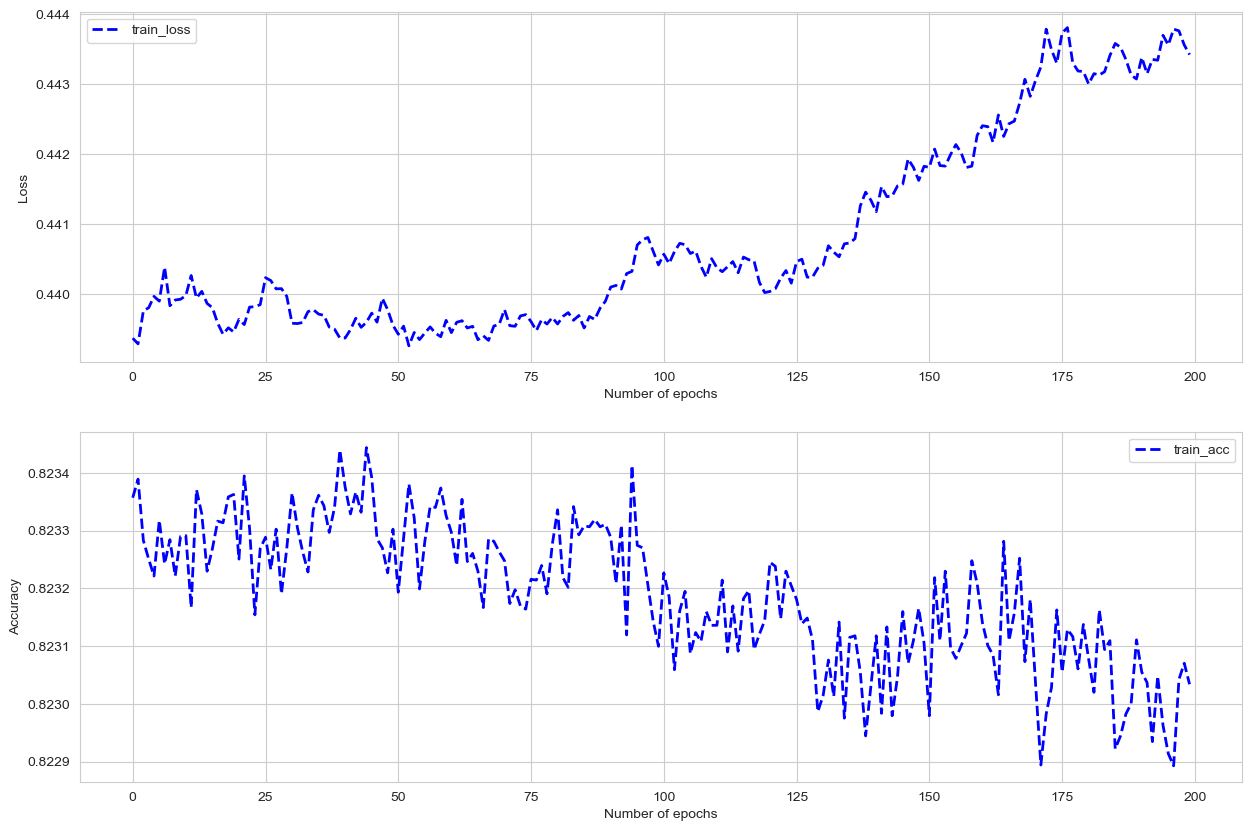

In [34]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
plt.legend()
# plt.ylim([.5,1.3])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'],'b--',lw=2,label='train_acc')
plt.legend()
# plt.ylim([.2,1.0])
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.show()

In [35]:
model.save('./models/classification_lstm')

INFO:tensorflow:Assets written to: ./models/classification_lstm/assets


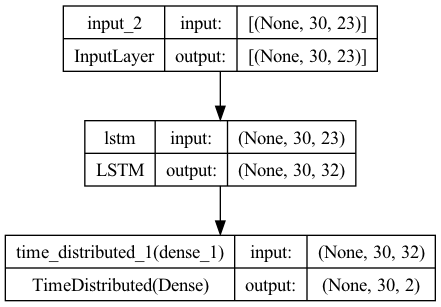

In [14]:
from keras.utils.vis_utils import plot_model #need to install graphviz and pydot for it to work
from IPython.display import Image
plot_model(model, to_file='./Images_model/classification_lstm.png', show_shapes=True, show_layer_names=True)

Image(filename='./Images_model/classification_lstm.png')